[![Open In Colab](https://colab.research.google.com/assets/colab-badge.svg)](https://colab.research.google.com/github/aurelio-labs/semantic-router/blob/main/docs/integrations/pydantic-ai/chatbot-with-guardrails.ipynb) [![Open nbviewer](https://raw.githubusercontent.com/pinecone-io/examples/master/assets/nbviewer-shield.svg)](https://nbviewer.org/github/aurelio-labs/semantic-router/blob/main/docs/integrations/pydantic-ai/chatbot-with-guardrails.ipynb)

## Sparse Encoder

### Install Prerequisites

In [1]:
#!pip install -qU \
#    semantic-router>=0.1.6 \
#    pydantic-ai>=0.0.42

### Creating Hybrid Router for Sparse Encoder Detection

To begin we first need to import the `Route` class from the `semantic_router` package.

Then we can define the routes that we want to use in our semantic router. For this example we will use routes for BYD, Tesla, Polestar, and Rivian. Giving each route a name and a list of utterances that we want to use to represent the route.


In [2]:
from semantic_router import Route

# Route for BYD-related queries (allowed)
byd = Route(
    name="byd",
    utterances=[
        "Tell me about the BYD Seal.",
        "What is the battery capacity of the BYD Dolphin?",
        "How does BYD's Blade Battery work?",
        "Is the BYD Atto 3 a good EV?",
        "Can I sell my BYD?",
        "How much is my BYD worth?",
        "What is the resale value of my BYD?",
        "How much can I get for my BYD?",
        "How much can I sell my BYD for?",
    ],
)

# Route for Tesla-related queries (blocked or redirected)
tesla = Route(
    name="tesla",
    utterances=[
        "Is Tesla better than BYD?",
        "Tell me about the Tesla Model 3.",
        "How does Tesla's autopilot compare to other EVs?",
        "What's new in the Tesla Cybertruck?",
        "Can I sell my Tesla?",
        "How much is my Tesla worth?",
        "What is the resale value of my Tesla?",
        "How much can I get for my Tesla?",
        "How much can I sell my Tesla for?",
    ],
)

# Route for Polestar-related queries (blocked or redirected)
polestar = Route(
    name="polestar",
    utterances=[
        "What's the range of the Polestar 2?",
        "Is Polestar a good alternative to other EVs?",
        "How does Polestar compare to other EVs?",
        "Can I sell my Polestar?",
        "How much is my Polestar worth?",
        "What is the resale value of my Polestar?",
        "How much can I get for my Polestar?",
        "How much can I sell my Polestar for?",
    ],
)

# Route for Rivian-related queries (blocked or redirected)
rivian = Route(
    name="rivian",
    utterances=[
        "Tell me about the Rivian R1T.",
        "How does Rivian's off-road capability compare to other EVs?",
        "Is Rivian's charging network better than other EVs?",
        "Can I sell my Rivian?",
        "How much is my Rivian worth?",
        "What is the resale value of my Rivian?",
        "How much can I get for my Rivian?",
        "How much can I sell my Rivian for?",
    ],
)

# Combine all routes
routes = [byd, tesla, polestar, rivian]

/Users/jamesbriggs/Documents/aurelio/semantic-router/.venv/lib/python3.13/site-packages/tqdm/auto.py:21: TqdmWarning: IProgress not found. Please update jupyter and ipywidgets. See https://ipywidgets.readthedocs.io/en/stable/user_install.html
  from .autonotebook import tqdm as notebook_tqdm


Relying solely on dense embedding models to differentiate between the meaning of these queries is _very_ difficult due to the nature of semantic space resulting in queries like `"can I sell my Tesla?"` and `"can I sell my Polestar?"` being incredibly semantically similar. We can test this with OpenAI's dense embedding model.

We will need an [OpenAI API key](https://platform.openai.com/api-keys) for this.

In [1]:
import os
from getpass import getpass
from semantic_router.encoders import OpenAIEncoder

os.environ["OPENAI_API_KEY"] = os.getenv("OPENAI_API_KEY") or getpass(
    "Enter your OpenAI API key: "
)
# dense encoder for semantic meaning
encoder = OpenAIEncoder(name="text-embedding-3-small", score_threshold=0.3)

/Users/jamesbriggs/Documents/aurelio/semantic-router/.venv/lib/python3.13/site-packages/tqdm/auto.py:21: TqdmWarning: IProgress not found. Please update jupyter and ipywidgets. See https://ipywidgets.readthedocs.io/en/stable/user_install.html
  from .autonotebook import tqdm as notebook_tqdm


Next let's compare the similarity between some vectors:

In [3]:
import numpy as np
from numpy.linalg import norm

vectors = encoder(
    docs=[
        "can I sell my Tesla?",
        "can I sell my Polestar?",
        "can I sell my BYD?",
        "can I sell my Rivian?",
    ]
)

# normalize our vectors
vector_norms = norm(vectors, axis=1, keepdims=True)
normalized_vectors = vectors / vector_norms

# calculate the dot product similarity between the vectors
dot_products = np.dot(normalized_vectors, normalized_vectors.T)
dot_products

2025-03-25 11:45:11 - httpx - INFO - _client.py:1013 - _send_single_request() - HTTP Request: POST https://api.openai.com/v1/embeddings "HTTP/1.1 200 OK"


array([[1.        , 0.65354249, 0.67416076, 0.69256556],
       [0.65354249, 1.        , 0.57430814, 0.59140332],
       [0.67416076, 0.57430814, 1.        , 0.60840109],
       [0.69256556, 0.59140332, 0.60840109, 1.        ]])

Now let's compare this to similarities between utterances of a single route:

In [10]:
vectors = encoder(
    docs=[
        "Tell me about the BYD Seal.",
        "How does BYD's Blade Battery work?",
        "Is the BYD Atto 3 a good EV?",
        "Can I sell my BYD?",
        "How much can I sell my BYD for?",
    ]
)

# normalize our vectors
vector_norms = norm(vectors, axis=1, keepdims=True)
normalized_vectors = vectors / vector_norms

# calculate the dot product similarity between the vectors
dot_products = np.dot(normalized_vectors, normalized_vectors.T)
dot_products

2025-03-25 11:50:27 - httpx - INFO - _client.py:1013 - _send_single_request() - HTTP Request: POST https://api.openai.com/v1/embeddings "HTTP/1.1 200 OK"


array([[1.        , 0.52624727, 0.48299403, 0.57280113, 0.55299787],
       [0.52624727, 1.        , 0.5188066 , 0.56618672, 0.55230486],
       [0.48299403, 0.5188066 , 1.        , 0.60667738, 0.58912712],
       [0.57280113, 0.56618672, 0.60667738, 1.        , 0.8838391 ],
       [0.55299787, 0.55230486, 0.58912712, 0.8838391 , 1.        ]])

In some cases here the utterances between different routes share higher similarity than utterances within the same route. That is because dense encoders excel at identifying the "generic" semantic meaning between phrases, but there are many cases (like this one) where we also need to give some importance to the matching of similar terms, such as "BYD" or "Tesla".

Traditional sparse encoders perform very well with _term matching_, and by merging both dense and sparse methods to create a _hybrid_ approach we can make the best of both worlds — scoring both on semantic meaning and term matching. Semantic router supports this via the `HybridRouter`. To use the hybrid methods we will first need to initialize a sparse encoder. We would typically need to "fit" (ie train) sparse encoders on our dataset, but we can use the pretrained `AurelioSparseEncoder` instead. For that we need an [API key](https://platform.aurelio.ai/settings/api-keys).

In [2]:
from semantic_router.encoders.aurelio import AurelioSparseEncoder

os.environ["AURELIO_API_KEY"] = os.getenv("AURELIO_API_KEY") or getpass(
    "Enter your Aurelio API key: "
)
# sparse encoder for term matching
sparse_encoder = AurelioSparseEncoder(name="bm25")

Now we have all the components needed to initialize our `HybridRouter`. We provide the `HybridRouter` with a dense `encoder`, `sparse_encoder`, our predefined `routes`, and we also set `auto_sync` to `"local"`:

In [4]:
from semantic_router.routers import HybridRouter

router = HybridRouter(
    encoder=encoder, sparse_encoder=sparse_encoder, routes=routes, auto_sync="local"
)

2025-03-21 15:12:39 - semantic_router.utils.logger - WARNING - hybrid.py:54 - __init__() - No index provided. Using default HybridLocalIndex.
2025-03-21 15:12:40 - httpx - INFO - _client.py:1025 - _send_single_request() - HTTP Request: POST https://api.openai.com/v1/embeddings "HTTP/1.1 200 OK"
2025-03-21 15:12:42 - httpx - INFO - _client.py:1025 - _send_single_request() - HTTP Request: POST https://api.openai.com/v1/embeddings "HTTP/1.1 200 OK"
2025-03-21 15:12:43 - semantic_router.utils.logger - WARNING - hybrid_local.py:47 - add() - Function schemas are not supported for HybridLocalIndex.
2025-03-21 15:12:43 - semantic_router.utils.logger - WARNING - hybrid_local.py:49 - add() - Metadata is not supported for HybridLocalIndex.
2025-03-21 15:12:43 - semantic_router.utils.logger - WARNING - hybrid_local.py:210 - _write_config() - No config is written for HybridLocalIndex.


To check the current route thresholds we can use the `get_thresholds` method which will return a dictionary of route names and their corresponding thresholds values in a float.

In [6]:
route_thresholds = router.get_thresholds()
print("Default route thresholds:", route_thresholds)

Default route thresholds: {'byd': 0.09, 'tesla': 0.09, 'polestar': 0.09, 'rivian': 0.09}


We can test our router already by passing in a list of utterances and seeing which route each utterance is routed to.

In [9]:
for utterance in [
    "Tell me about BYD's Blade Battery.",
    "Does the Tesla Model 3 have better range?",
    "What are the key features of the Polestar 2?",
    "Is Rivian's R1T better for off-roading?",
]:
    print(f"{utterance} -> {router(utterance).name}")

2025-03-21 15:12:43 - httpx - INFO - _client.py:1025 - _send_single_request() - HTTP Request: POST https://api.openai.com/v1/embeddings "HTTP/1.1 200 OK"


Tell me about BYD's Blade Battery. -> byd


2025-03-21 15:12:44 - httpx - INFO - _client.py:1025 - _send_single_request() - HTTP Request: POST https://api.openai.com/v1/embeddings "HTTP/1.1 200 OK"


Does the Tesla Model 3 have better range? -> tesla


2025-03-21 15:12:45 - httpx - INFO - _client.py:1025 - _send_single_request() - HTTP Request: POST https://api.openai.com/v1/embeddings "HTTP/1.1 200 OK"


What are the key features of the Polestar 2? -> polestar


2025-03-21 15:12:49 - httpx - INFO - _client.py:1025 - _send_single_request() - HTTP Request: POST https://api.openai.com/v1/embeddings "HTTP/1.1 200 OK"


Is Rivian's R1T better for off-roading? -> rivian


The `HybridRouter` is already performing reasonably well. We can use the `evaluate` method to measure the router's accuracy across a larger set of test data.

In [10]:
test_data = [
    ("Tell me about BYD's Blade Battery.", "byd"),
    ("Does the Tesla Model 3 have better range?", "tesla"),
    ("What are the key features of the Polestar 2?", "polestar"),
    ("Is Rivian's R1T better for off-roading?", "rivian"),
]

# unpack the test data
X, y = zip(*test_data)

# evaluate using the default thresholds
accuracy = router.evaluate(X=X, y=y)
print(f"Accuracy: {accuracy * 100:.2f}%")

Generating embeddings: 100%|██████████| 1/1 [00:01<00:00,  1.14s/it]

Accuracy: 100.00%


From this small test set it seems like we have perfect performance, but a small dataset like this is _not_ enough to give us any reasonable confidence in our router's performance. Instead we should gather as large a dataset covering as many queries that we might expect users to try. It's also important to include routes that we would expect to _not_ trigger any routes, we mark these as `None` utterances.

In [11]:
test_data = [
    # BYD-related queries
    ("Tell me about the BYD Seal.", "byd"),
    ("What is the battery capacity of the BYD Dolphin?", "byd"),
    ("How does BYD's Blade Battery work?", "byd"),
    ("Is the BYD Atto 3 a good EV?", "byd"),
    ("What's the range of the BYD Tang?", "byd"),
    ("Does BYD offer fast-charging stations?", "byd"),
    ("How is the BYD Han different from the Seal?", "byd"),
    ("Is BYD the largest EV manufacturer in China?", "byd"),
    ("What is the top speed of the BYD Seal?", "byd"),
    ("Compare the BYD Dolphin and the BYD Atto 3.", "byd"),
    ("How does BYD's battery technology compare to Tesla's?", "byd"),
    ("What makes the BYD Blade Battery safer?", "byd"),
    ("Does BYD have plans to expand to Europe?", "byd"),
    ("How efficient is the BYD Tang in terms of range?", "byd"),
    ("What are the latest BYD electric vehicle models?", "byd"),
    ("How does the BYD Han compare to the Tesla Model S?", "byd"),
    ("What is the warranty on BYD EV batteries?", "byd"),
    ("Which BYD model is the best for long-distance driving?", "byd"),
    ("Does BYD manufacture its own battery cells?", "byd"),
    # Tesla-related queries
    ("Is Tesla better than BYD?", "tesla"),
    ("Tell me about the Tesla Model 3.", "tesla"),
    ("How does Tesla's autopilot compare to other EVs?", "tesla"),
    ("What's new in the Tesla Cybertruck?", "tesla"),
    ("What is Tesla's Full Self-Driving feature?", "tesla"),
    ("How long does it take to charge a Tesla?", "tesla"),
    ("Tell me about the Tesla Roadster.", "tesla"),
    ("How much does a Tesla Model S cost?", "tesla"),
    ("Which Tesla model has the longest range?", "tesla"),
    ("What are the main differences between the Tesla Model S and Model 3?", "tesla"),
    ("How safe is Tesla's Autopilot?", "tesla"),
    ("Does Tesla use LFP batteries?", "tesla"),
    ("What is the Tesla Supercharger network?", "tesla"),
    ("How does Tesla's Plaid mode work?", "tesla"),
    ("Which Tesla is best for off-roading?", "tesla"),
    # Polestar-related queries
    ("What's the range of the Polestar 2?", "polestar"),
    ("Is Polestar a good alternative?", "polestar"),
    ("How does Polestar compare to Tesla?", "polestar"),
    ("Tell me about the Polestar 3.", "polestar"),
    ("Is the Polestar 2 fully electric?", "polestar"),
    ("What is Polestar's performance like?", "polestar"),
    ("Does Polestar offer any performance upgrades?", "polestar"),
    ("How is Polestar's autonomous driving technology?", "polestar"),
    ("What is the battery capacity of the Polestar 2?", "polestar"),
    ("How does Polestar differ from Volvo?", "polestar"),
    ("Is Polestar planning a fully electric SUV?", "polestar"),
    ("How does the Polestar 4 compare to other EVs?", "polestar"),
    ("What are Polestar's sustainability goals?", "polestar"),
    ("How much does a Polestar 3 cost?", "polestar"),
    ("Does Polestar have its own fast-charging network?", "polestar"),
    # Rivian-related queries
    ("Tell me about the Rivian R1T.", "rivian"),
    ("How does Rivian's off-road capability compare to other EVs?", "rivian"),
    ("Is Rivian's charging network better than other EVs?", "rivian"),
    ("What is the range of the Rivian R1S?", "rivian"),
    ("How much does a Rivian R1T cost?", "rivian"),
    ("Tell me about Rivian's plans for new EVs.", "rivian"),
    ("How does Rivian's technology compare to other EVs?", "rivian"),
    ("What are the best off-road features of the Rivian R1T?", "rivian"),
    ("What's the towing capacity of the Rivian R1T?", "rivian"),
    ("How does the Rivian R1S differ from the R1T?", "rivian"),
    ("What's special about Rivian's adventure network?", "rivian"),
    ("How much does it cost to charge a Rivian?", "rivian"),
    ("Does Rivian have a lease program?", "rivian"),
    ("What are Rivian's future expansion plans?", "rivian"),
    ("How long does it take to charge a Rivian at home?", "rivian"),
    # None category (general knowledge)
    ("What is the capital of France?", None),
    ("How many people live in the US?", None),
    ("When is the best time to visit Bali?", None),
    ("How do I learn a language?", None),
    ("Tell me an interesting fact.", None),
    ("What is the best programming language?", None),
    ("I'm interested in learning about llama 2.", None),
    ("What is the capital of the moon?", None),
    ("Who was the first person to walk on the moon?", None),
    ("What's the best way to cook a steak?", None),
    ("How do I start a vegetable garden?", None),
    ("What's the most popular dog breed?", None),
    ("Tell me about the history of the Roman Empire.", None),
    ("How do I improve my photography skills?", None),
    ("What are some good book recommendations?", None),
    ("How does the stock market work?", None),
    ("What's the best way to stay fit?", None),
    ("What's the weather like in London today?", None),
    ("Who won the last FIFA World Cup?", None),
    ("What's the difference between a crocodile and an alligator?", None),
    ("Tell me about the origins of jazz music.", None),
    ("What's the fastest animal on land?", None),
    ("How does Bitcoin mining work?", None),
    ("What are the symptoms of the flu?", None),
    ("How do I start a YouTube channel?", None),
    ("What's the best travel destination for solo travelers?", None),
    ("Who invented the light bulb?", None),
    ("What are the rules of chess?", None),
    ("Tell me about ancient Egyptian mythology.", None),
    ("How do I train my dog to sit?", None),
    ("What's the difference between espresso and regular coffee?", None),
    ("What's a good beginner-friendly programming language?", None),
    ("What are some good stretching exercises?", None),
    ("How do I bake a chocolate cake?", None),
    ("What's the best way to save money?", None),
    ("How do airplanes stay in the air?", None),
    ("What are the benefits of meditation?", None),
    ("How do I learn basic Spanish?", None),
    ("What's the best way to pack for a trip?", None),
    ("What's the most common phobia?", None),
    ("How do I take care of a bonsai tree?", None),
    ("What's the best way to clean a laptop keyboard?", None),
    ("Tell me about the Great Wall of China.", None),
    ("What's the best way to learn to swim?", None),
    ("How does WiFi work?", None),
    ("What's the healthiest type of bread?", None),
    ("What's the origin of the word 'quarantine'?", None),
    ("How do I find a good apartment?", None),
    ("What are some good mindfulness techniques?", None),
    ("How do I set up a home theater system?", None),
]

Using the new test data we can also evaluate the router with a higher degree of accuracy due to the larger dataset.

In [12]:
# unpack the test data
X, y = zip(*test_data)

X = list(X)
y = list(y)

print(X)
print(y)

['Tell me about the BYD Seal.', 'What is the battery capacity of the BYD Dolphin?', "How does BYD's Blade Battery work?", 'Is the BYD Atto 3 a good EV?', 'What’s the range of the BYD Tang?', 'Does BYD offer fast-charging stations?', 'How is the BYD Han different from the Seal?', 'Is BYD the largest EV manufacturer in China?', 'What is the top speed of the BYD Seal?', 'Compare the BYD Dolphin and the BYD Atto 3.', 'How does BYD’s battery technology compare to Tesla’s?', 'What makes the BYD Blade Battery safer?', 'Does BYD have plans to expand to Europe?', 'How efficient is the BYD Tang in terms of range?', 'What are the latest BYD electric vehicle models?', 'How does the BYD Han compare to the Tesla Model S?', 'What is the warranty on BYD EV batteries?', 'Which BYD model is the best for long-distance driving?', 'Does BYD manufacture its own battery cells?', 'Is Tesla better than BYD?', 'Tell me about the Tesla Model 3.', 'How does Tesla’s autopilot compare to other EVs?', 'What’s new in

We can now look at the default route thresholds and showcase the change in accuracy when we change the threshold.

In [13]:
router.set_threshold(route_name="byd", threshold=0.42424242424242425)
router.set_threshold(route_name="tesla", threshold=0.31313131313131315)
router.set_threshold(route_name="polestar", threshold=0.84640342822161)
router.set_threshold(route_name="rivian", threshold=0.12121212121212122)

We can set the threshold manually and see the change in accuracy.

In [14]:
route_thresholds = router.get_thresholds()
print("Default route thresholds:", route_thresholds)

Default route thresholds: {'byd': 0.42424242424242425, 'tesla': 0.31313131313131315, 'polestar': 0.84640342822161, 'rivian': 0.12121212121212122}


In [15]:
# evaluate using the default thresholds
accuracy = router.evaluate(X=X, y=y)
print(f"Accuracy: {accuracy * 100:.2f}%")

Generating embeddings: 100%|██████████| 1/1 [00:02<00:00,  2.85s/it]

Accuracy: 85.09%


Or we can use the `fit` method to fit the router to the test data which should give us the best accuracy possible based on the thresholds.

In [16]:
# Call the fit method
router.fit(X=X, y=y)

Training:   2%|▏         | 8/500 [00:00<00:14, 33.88it/s, acc=0.93]

New best accuracy: 0.9298245614035088
New best thresholds: {'byd': 0.6161616161616162, 'tesla': 0.6161616161616162, 'polestar': 0.4499540863177227, 'rivian': 0.5483838383838384}


Training:  30%|███       | 151/500 [00:05<00:10, 32.89it/s, acc=0.94]

New best accuracy: 0.9385964912280702
New best thresholds: {'byd': 0.5252525252525253, 'tesla': 0.574811475637922, 'polestar': 0.686868686868687, 'rivian': 0.42185243929963856}


Training: 100%|██████████| 500/500 [00:17<00:00, 29.00it/s, acc=0.94]


In [17]:
route_thresholds = router.get_thresholds()
print("Updated route thresholds:", route_thresholds)

Updated route thresholds: {'byd': 0.5252525252525253, 'tesla': 0.574811475637922, 'polestar': 0.686868686868687, 'rivian': 0.42185243929963856}


In [18]:
accuracy = router.evaluate(X=X, y=y)
print(f"Accuracy: {accuracy * 100:.2f}%")

Generating embeddings: 100%|██████████| 1/1 [00:03<00:00,  3.24s/it]

Accuracy: 93.86%


### Creating Second Hybrid Router for Scam Detection

In this section we are repeating the same process as before but for a different router.

This router will instead be a scam detector router, looking for common scam utterances and redirecting them to a different route.

In [19]:
# Route for BYD-related queries (allowed)
scam = Route(
    name="scam",
    utterances=[
        "Can you give me a discount?",
        "I need to pay you in bitcoin",
        "I need to pay you in cash",
        "I need to pay you in gift card",
        "I want you to pay me in bitcoin",
        "I want you to pay me in cash",
        "I want you to pay me in gift card",
        "Could you lower the price?",
    ],
)

# Route for Tesla-related queries (blocked or redirected)
other = Route(
    name="other",
    utterances=[
        "What is the price of the product?",
        "What is the delivery time?",
        "What is the return policy?",
        "What is the warranty?",
        "What is the refund policy?",
        "What is the shipping cost?",
        "What is the shipping time?",
        "What is the shipping policy?",
        "How much can I sell my EV for?",
        "How much can I sell my Tesla for?",
        "How much can I sell my Polestar for?",
        "How much can I sell my Rivian for?",
        "How much can I sell my BYD for?",
        "How much can I sell my other EV for?",
    ],
)

# Combine all routes
routes = [scam, other]

In [20]:
second_router = HybridRouter(
    encoder=encoder, sparse_encoder=sparse_encoder, routes=routes, auto_sync="local"
)

2025-03-21 15:13:17 - semantic_router.utils.logger - WARNING - hybrid.py:54 - __init__() - No index provided. Using default HybridLocalIndex.
2025-03-21 15:13:18 - httpx - INFO - _client.py:1025 - _send_single_request() - HTTP Request: POST https://api.openai.com/v1/embeddings "HTTP/1.1 200 OK"
2025-03-21 15:13:18 - httpx - INFO - _client.py:1025 - _send_single_request() - HTTP Request: POST https://api.openai.com/v1/embeddings "HTTP/1.1 200 OK"
2025-03-21 15:13:19 - semantic_router.utils.logger - WARNING - hybrid_local.py:47 - add() - Function schemas are not supported for HybridLocalIndex.
2025-03-21 15:13:19 - semantic_router.utils.logger - WARNING - hybrid_local.py:49 - add() - Metadata is not supported for HybridLocalIndex.
2025-03-21 15:13:19 - semantic_router.utils.logger - WARNING - hybrid_local.py:210 - _write_config() - No config is written for HybridLocalIndex.


In [21]:
test_data = [
    # scam routes
    ("Can you give me a discount?", "scam"),
    ("I need to pay you in bitcoin", "scam"),
    ("I need to pay you in cash", "scam"),
    ("I need to pay you in gift card", "scam"),
    ("I want you to pay me in bitcoin", "scam"),
    ("I want you to pay me in cash", "scam"),
    ("I want you to pay me in gift card", "scam"),
    ("Could you lower the price?", "scam"),
    ("Can I pay with cryptocurrency?", "scam"),
    ("Do you accept payments through Venmo only?", "scam"),
    ("Can I send you money via Western Union?", "scam"),
    ("Can I overpay and get a refund?", "scam"),
    ("Can we complete this deal outside the platform?", "scam"),
    ("I'll pay you later, just ship it now.", "scam"),
    ("Can I get a refund without returning the item?", "scam"),
    ("I'll send extra money if you process this quickly.", "scam"),
    ("Can you mark this transaction as a gift?", "scam"),
    ("Can I use multiple gift cards to pay?", "scam"),
    ("Can you split the payment across different methods?", "scam"),
    ("Can you wire me money first as a guarantee?", "scam"),
    ("Can you send the product before I pay?", "scam"),
    ("Can you help me transfer money?", "scam"),
    ("Can you provide fake receipts?", "scam"),
    ("Can you process my payment through an unusual method?", "scam"),
    ("Can I pay you in prepaid debit cards?", "scam"),
    # other routes
    ("What is the price of the product?", "other"),
    ("What is the delivery time?", "other"),
    ("What is the return policy?", "other"),
    ("Do you offer international shipping?", "other"),
    ("How long does it take for delivery?", "other"),
    ("Is there a warranty for this product?", "other"),
    ("Do you provide customer support?", "other"),
    ("Can I track my order?", "other"),
    ("Is express shipping available?", "other"),
    ("What payment methods do you accept?", "other"),
    ("Do you offer bulk discounts?", "other"),
    ("What are the shipping costs?", "other"),
    ("Can I cancel my order?", "other"),
    ("Do you have a physical store?", "other"),
    ("Can I change my shipping address?", "other"),
    ("Is there a restocking fee for returns?", "other"),
    ("Do you have customer reviews?", "other"),
    ("Is this product available in other colors?", "other"),
    ("Do you provide installation services?", "other"),
    ("How can I contact customer service?", "other"),
    ("Are there any current promotions or sales?", "other"),
    ("Can I pick up my order instead of delivery?", "other"),
    # add some None routes to prevent excessively small thresholds
    ("What is the capital of France?", None),
    ("How many people live in the US?", None),
    ("When is the best time to visit Bali?", None),
    ("How do I learn a language?", None),
    ("Tell me an interesting fact.", None),
    ("What is the best programming language?", None),
    ("I'm interested in learning about llama 2.", None),
    ("What is the capital of the moon?", None),
    ("Who discovered gravity?", None),
    ("What are some healthy breakfast options?", None),
    ("How do I start a vegetable garden?", None),
    ("What are the symptoms of the flu?", None),
    ("What's the most spoken language in the world?", None),
    ("How does WiFi work?", None),
    ("What are the benefits of meditation?", None),
    ("How do I improve my memory?", None),
    ("What is the speed of light?", None),
    ("Who wrote 'To Kill a Mockingbird'?", None),
    ("How does an electric car work?", None),
    ("What's the best way to save money?", None),
    ("How do I bake a chocolate cake?", None),
    ("What's the healthiest type of bread?", None),
    ("Who invented the internet?", None),
    ("How do airplanes stay in the air?", None),
    ("What are some famous landmarks in Italy?", None),
    ("What's the difference between a virus and bacteria?", None),
    ("How do I learn to play the guitar?", None),
    ("What's the best way to learn to swim?", None),
    ("What's the tallest mountain in the world?", None),
    ("How does the stock market work?", None),
]

In [22]:
# unpack the test data
X, y = zip(*test_data)

X = list(X)
y = list(y)

print(X)
print(y)

['Can you give me a discount?', 'I need to pay you in bitcoin', 'I need to pay you in cash', 'I need to pay you in gift card', 'I want you to pay me in bitcoin', 'I want you to pay me in cash', 'I want you to pay me in gift card', 'Could you lower the price?', 'Can I pay with cryptocurrency?', 'Do you accept payments through Venmo only?', 'Can I send you money via Western Union?', 'Can I overpay and get a refund?', 'Can we complete this deal outside the platform?', "I'll pay you later, just ship it now.", 'Can I get a refund without returning the item?', 'I’ll send extra money if you process this quickly.', 'Can you mark this transaction as a gift?', 'Can I use multiple gift cards to pay?', 'Can you split the payment across different methods?', 'Can you wire me money first as a guarantee?', 'Can you send the product before I pay?', 'Can you help me transfer money?', 'Can you provide fake receipts?', 'Can you process my payment through an unusual method?', 'Can I pay you in prepaid debi

In [23]:
# Call the fit method
second_router.fit(X=X, y=y)

Training:   4%|▎         | 18/500 [00:00<00:05, 87.06it/s, acc=0.81]

New best accuracy: 0.5974025974025974
New best thresholds: {'scam': 0.6248586878889909, 'other': 0.8353310886644221}
New best accuracy: 0.7142857142857143
New best thresholds: {'scam': 0.516131007040098, 'other': 0.37373737373737376}
New best accuracy: 0.8051948051948052
New best thresholds: {'scam': 0.40541959544218364, 'other': 0.4646464646464647}


Training:   9%|▊         | 43/500 [00:00<00:06, 70.88it/s, acc=0.82]

New best accuracy: 0.8181818181818182
New best thresholds: {'scam': 0.24242424242424243, 'other': 0.36363636363636365}


Training:  17%|█▋        | 83/500 [00:01<00:06, 63.96it/s, acc=0.83]

New best accuracy: 0.8311688311688312
New best thresholds: {'scam': 0.30303030303030304, 'other': 0.4747474747474748}


Training: 100%|██████████| 500/500 [00:07<00:00, 68.13it/s, acc=0.83]


In [24]:
accuracy = second_router.evaluate(X=X, y=y)
print(f"Accuracy: {accuracy * 100:.2f}%")

Generating embeddings: 100%|██████████| 1/1 [00:03<00:00,  3.06s/it]

Accuracy: 83.12%


In [25]:
route_thresholds = second_router.get_thresholds()
print("Updated route thresholds:", route_thresholds)

Updated route thresholds: {'scam': 0.30303030303030304, 'other': 0.4747474747474748}


### Creating Pydantic AI Graph with Sparse Router Detection

Now we are moving on to use this router in a Pydantic graph.

First we will need to import the `nest_asyncio` library to allow nested event loops.

Then as we are using Pydantic AI without logfire we need to set the `LOGFIRE_IGNORE_NO_CONFIG` environment variable to `1` to ignore the no config error.

In [26]:
import nest_asyncio

# this is needed to allow nested event loops
nest_asyncio.apply()

# this is needed to ignore the no config error
os.environ["LOGFIRE_IGNORE_NO_CONFIG"] = "1"

Now we can import the `Agent` class from the `pydantic_ai` package.

With this we can define the agent and pass in the `gpt-4o-mini` large language model.

In [27]:
from pydantic_ai import Agent

agent = Agent(model="gpt-4o-mini")

We can also add a final layer of protection to the agent by adding a `system_prompt` that will be used to guide the agent's behavior.

In [28]:
@agent.system_prompt  # using the system prompt decorator allows us to add additional information to the system prompt
def how_to_respond() -> (
    str
):  # this is the dependency that will be used in the system prompt
    return """You are a helpful assistant designed to only respond to queries about BYD, 
    however if the user asks you for any form of discount or negotiation you tell them 'We dont do discounts here'."""

We also need to define the graph state which will be used to store the query and response.

To do this we will use the `dataclass` decorator from the `dataclasses` module.

Then we can create a custom class that contains the query and response.

In [29]:
from dataclasses import dataclass


@dataclass
class graph_state:
    query: str
    response: str

Now we want to define the nodes that will be used in the graph.

We will create a class that inherits from the `BaseNode` class from the `pydantic_graph` package.

Then we can define a `run` method that will be used to communicate between the nodes.

For this example we will create a `Respond` node that will use the `agent` to respond to the user's query.

We will also create a `Check` node that will use the `router` to check which route the user's query should be routed to.

If the query is about BYD we will respond with a message, however if the query is about Tesla, Polestar, or Rivian we will respond with a different predefined message.

In [30]:
from pydantic_graph import BaseNode, End, Graph, GraphRunContext
from __future__ import annotations


@dataclass
class Respond(BaseNode[graph_state, None, str]):
    async def run(self, ctx: GraphRunContext) -> End[str]:
        ctx.state.response = agent.run_sync(user_prompt=ctx.state.query)
        return End(ctx.state.response)


@dataclass
class Check(BaseNode[graph_state, None, str]):
    async def run(self, ctx: GraphRunContext) -> CheckScam | End[str]:
        result = router(text=ctx.state.query)
        if result.name == "byd":
            return CheckScam()
        else:
            ctx.state.response = f"We dont talk about {result.name} here"
            return End(ctx.state.response)


@dataclass
class CheckScam(BaseNode[graph_state, None, str]):
    async def run(self, ctx: GraphRunContext) -> Respond | End[str]:
        result = second_router(text=ctx.state.query)
        if result.name == "other":
            return Respond()
        else:
            ctx.state.response = f"We dont do {result.name}s here"
            return End(ctx.state.response)

Next we want to build the graph by passing the nodes into the `Graph` class alongside a name for the graph.

In [31]:
semantic_graph = Graph(name="Semantic Graph", nodes=(Check, CheckScam, Respond))

We can then use the `mermaid_image` method to display the graph via image bytes.

This needs to be converted to an image to display via the `display` function.

2025-03-21 15:13:33 - httpx - INFO - _client.py:1025 - _send_single_request() - HTTP Request: GET https://mermaid.ink/img/LS0tCnRpdGxlOiBTZW1hbnRpYyBHcmFwaAotLS0Kc3RhdGVEaWFncmFtLXYyCiAgQ2hlY2sgLS0+IENoZWNrU2NhbQogIENoZWNrIC0tPiBbKl0KICBDaGVja1NjYW0gLS0+IFJlc3BvbmQKICBDaGVja1NjYW0gLS0+IFsqXQogIFJlc3BvbmQgLS0+IFsqXQ== "HTTP/1.1 200 OK"


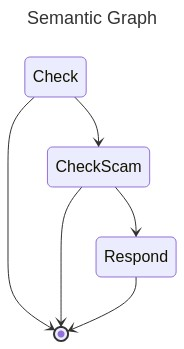

In [32]:
from IPython.display import Image, display

image_bytes = semantic_graph.mermaid_image(infer_name=True)

display(Image(data=image_bytes))

Now we can test the graph by passing in a query via the graph state we set up earlier.

In [35]:
result = await semantic_graph.run(
    start_node=Check(),
    state=graph_state(query="What is the price of a BYD?", response=""),
)

2025-03-21 15:14:13 - httpx - INFO - _client.py:1025 - _send_single_request() - HTTP Request: POST https://api.openai.com/v1/embeddings "HTTP/1.1 200 OK"
2025-03-21 15:14:14 - httpx - INFO - _client.py:1025 - _send_single_request() - HTTP Request: POST https://api.openai.com/v1/embeddings "HTTP/1.1 200 OK"
2025-03-21 15:14:16 - httpx - INFO - _client.py:1740 - _send_single_request() - HTTP Request: POST https://api.openai.com/v1/chat/completions "HTTP/1.1 200 OK"


Then using the `state` attribute we can print the response and query.

In [36]:
print("Response: ", result.state.response)
print("Query: ", result.state.query)

Response:  AgentRunResult(data="The price of a BYD vehicle varies depending on the model and trim level. For example, the prices of popular models like the BYD Han, BYD Tang, or BYD Dolphin can differ significantly. It's best to check the official BYD website or local dealerships for the most accurate and up-to-date pricing information specific to your area and the model you are interested in.")
Query:  What is the price of a BYD?
